# Pi Day 2023

Welcome to the inaugural post of Blog Base Two—a math and computer science blog! This post emerged from the conjunction of three events: Pi Day, an interest in Galton boards, and a desire to start a blog. So, in the spirit of Matt Parker, I will attempt to calculate $\pi$ experimentally using a Galton board. Or at least that was the plan. I didn't have time to acquire a Galton board or to run the necessary experiments, so I'll have to settle for simulation. Additionally, I didn't really have time to dive into the mathematics, so that will have to be saved for follow-up articles. Instead, we're going to follow a pretty direct path to computing $\pi$.

To calculate $\pi$ experimentally, we need two things:

1. An experimental result that follows a known distribution, and
2. A formula relating that distribution to $\pi$.

## Finding Binomial Coefficients with a Galton Board

Probably the most note-worthy property of Galton boards is its relationship to the binomial distribution. The binomial distribution asks, "of $n$ trials with a probability $p$ of success, how likely is it that $r$ of them succeed?" In a Galton board, as the balls fall, they bounce off of pins and have a 50/50 chance of going either left or right (i.e., $p = .5$). For $n$ rows of pins, there will be $n + 1$ bins at the bottom for the balls to fall in. If we number those bins from left to right, 0, 1, 2, ..., $n$, then each bin's label represents how many times the ball bounced right. In other words, all the paths with $r$ right bounces end up in bin $r$. From the binomial theorem, we get that:

$$\sum_{r = 0}^n {n \choose r} = 2^n$$

Therefore, if we drop $2^n$ balls into a Galton board with $n$ rows of pins and $n + 1$ bins, ${n \choose r}$ of them will land in bin $r$. Let's see if that works in practice.


Actual: [0, 11, 116, 446, 1460, 2990, 4955, 6433, 6505, 4981, 3008, 1286, 464, 102, 8, 3]
Expected: [1, 15, 105, 455, 1365, 3003, 5005, 6435, 6435, 5005, 3003, 1365, 455, 105, 15, 1]


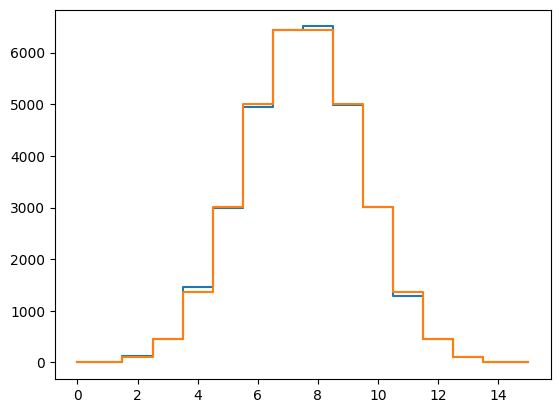

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

n = 15
bins = [0]*(n + 1)

for _ in range(2**n):
    r = 0

    # At each row the ball bounces right 50% of the time
    for _ in range(n):
        r += np.random.choice((False, True))

    # Bin ID = number of right bounces
    bins[r] += 1

# Expected distribution
dist = [math.comb(n, r) for r in range(n + 1)]

print("Actual:", bins)
print("Expected:", dist)

rs = np.arange(n + 1)

fig, ax = plt.subplots()
ax.step(rs, bins, where="mid")
ax.step(rs, dist, where="mid")

We can see that the experimental result matches the expected result very closely, but this is a very inefficient way to simulate the Galton board, which will really matter later.

As a baseline, we'll use our existing Galton board simulator to create a choose function.

In [2]:
from timeit import timeit

import numpy as np

def ncr(n, r):
    bins = [0]*(n + 1)

    # Drop balls one at a time
    for _ in range(2**n):
        num_right = 0

        # At each row the ball bounces right 50% of the time
        for _ in range(n):
            num_right += np.random.choice((False, True))

        # Bin ID = number of right bounces
        bins[num_right] += 1

    return bins[r]

timeit(lambda: ncr(11, 5), number=100)

48.71228667208925

Wow... that is bad!

As a first attempt at optimization, we can make all the left/right choices for a single drop at once. We can also get rid of all the bins except for the one we're interested in by doing $2^n$ ball drops, and counting how many end up in $r$.

In [3]:
from timeit import timeit

import numpy as np

def ncr(n, r):
    # Bucket = # of rights
    drop_ball = lambda: np.sum(np.random.choice((0, 1), n))

    # Count the number of times a ball ends up in bucket r
    return sum(drop_ball() == r for _ in range(2**n))

timeit(lambda: ncr(11, 5), number=100)

9.311325239017606

This is a massive improvement, but we can do better. Why not just generate $2^n$ binomially distributed random numbers and then filter them to the ones that equal $r$ (i.e., how many right turns). Then, count how many of them are left (i.e., how many ended up in bucket $r$).

In [4]:
import timeit

import numpy as np

def ncr(n, r):
    return np.count_nonzero(np.random.binomial(n, 0.5, 2**n) == r)

timeit(lambda: ncr(11, 5), number=100)

0.019961201935075223

Holy schnikes, that's fast! Partly this is due to being a more efficient algorithm, but it is also due to the fact that we do all the work entirely within Numpy which is both very efficient and written in C. Again, I may elaborate on this in a future post. For now, we have a fast way to simulate Galton board drops of $2^n$ balls, i.e., ${n \choose r}$.

Experimental: [0, 15, 100, 456, 1377, 2955, 4869, 6439, 6440, 5028, 3007, 1343, 503, 93, 13, 1]
Theoretical: [1, 15, 105, 455, 1365, 3003, 5005, 6435, 6435, 5005, 3003, 1365, 455, 105, 15, 1]


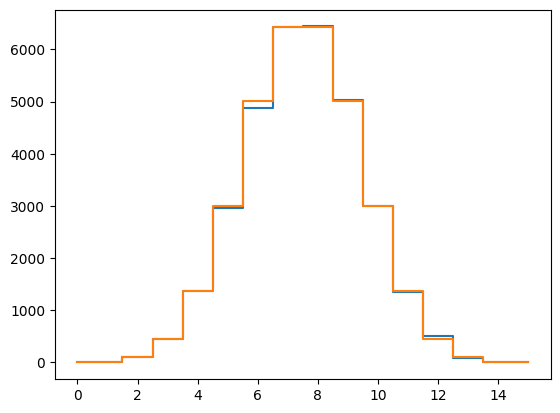

In [5]:
import math

import matplotlib.pyplot as plt
import numpy as np

def ncr(n, r):
    return np.count_nonzero(np.random.binomial(n, 0.5, 2**n) == r)

n = 15

rs = np.arange(n + 1)

bins = [ncr(n, r) for r in rs]
dist = [math.comb(n, r) for r in rs]

print("Experimental:", bins)
print("Theoretical:", dist)

fig, ax = plt.subplots()
ax.step(rs, bins, where="mid")
ax.step(rs, dist, where="mid")

This is looking promising. Now, how do we turn this into $\pi$?

## Pi in Terms of Binomial Coefficients



After some quick searching around the internet, I first came across Stirling's approximation for factorial, which includes $\pi$. It's not hard to solve for $\pi$, choose a value for $n$ and then use a Galton board to simulator $n!$. However, this method converges very slowly, so is impractical for finding a decent value of $\pi$.

Back to the drawing board. I then searched around for efficient algorithms, and tried to find one with the choose function in it. It turns out that if you take partial sums of the Maclaurin series of arcsin evaluated at $\frac{1}{2}$, you get a very good approximation of $\frac{\pi}{6}$ that converges very quickly. After some simplifications and solving for $\pi$, we get the following:

$$\pi \approx p(m) = 3\sum_{k=0}^{m - 1} {2k \choose k} 16^{-k}(2k + 1)^{-1}$$

Where $m$ is the number of terms to use for approximation. As you can see, it contains the choose function. Yes! Let's try it out with theoretical results first.

Found pi to 8 decimal places using only 11 terms:

p(11):	3.14159265
pi:	3.14159265


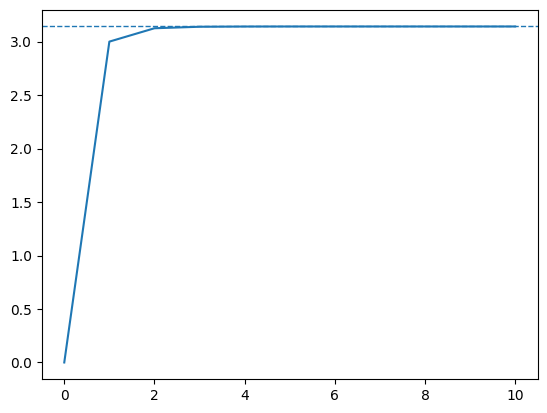

In [6]:
import math

import numpy as np
import matplotlib.pyplot as plt

p = lambda m: 3*sum(math.comb(2*k, k)/((16**k)*(2*k + 1)) for k in range(m))
accuracy = 8   # Target number of decimal places

for m in range(1000):
    if np.pi - p(m) < 10**(-accuracy):
        break

print(f"Found pi to {accuracy} decimal places using only {m} terms:\n")

print(f"p({m}):", f"{p(m):.{accuracy}f}", sep="\t")
print("pi:", f"{np.pi:.{accuracy}f}", sep="\t")

ms = np.arange(m)

fig, ax = plt.subplots()
ax.plot(ms, [p(m) for m in ms])
ax.axhline(np.pi, linestyle="--", linewidth=1)

As you can see, it converges *very* quickly. It is also very efficient for computers to compute due to the abundance of powers of two. Now just to put it all together.

## Putting it All Together

We have a nice algorithm for simulating the choose function with a Galton board and we have a nice formula for approximating $\pi$ using the choose function. Let's see how good the results are.

In [7]:
import numpy as np

def ncr(n, r):
    return np.count_nonzero(np.random.binomial(n, 0.5, 2**n) == r)

m = 11
p = 7

for _ in range(10):
    print(3*sum(ncr(2*r, r)/((16**r)*(2*r + 1)) for r in range(m)))

3.2050253902195496
3.143063689045558
3.086586430444402
3.141302985519995
3.2013097430082116
3.208823264039574
3.1376386818386677
3.146279694063442
3.2013785107538713
3.1416057355144886


We can see that though the accuracy is good, the precision is not great. We could increase the number of terms, but this won't actually help. We already know that 11 terms gets us 8 decimal places! What we need to do is increase the precision of our choose function. The only way to increase the precision of a random process is to increase the number of trials (recall, one way to think about probability distributions is as the distribution a certain process approaches as the number of trials approaches infinity). However, our number of trials are linked to the values of $n$ which are chosen for us by the $\pi$ formula. What if we back track a bit and instead of using the Galton board to compute choose, we use it to compute the probability by dropping in a large number of balls and seeing what percentage land in the bin we want. We can then just multiply that probability by $2^n$ to get ${n \choose r}$.

Let's start by seeing how precise our old choose function was for comparison.

Experimental: [2, 9, 50, 181, 362, 472, 453, 323, 158, 48, 11, 1]
Theoretical: [1, 11, 55, 165, 330, 462, 462, 330, 165, 55, 11, 1]


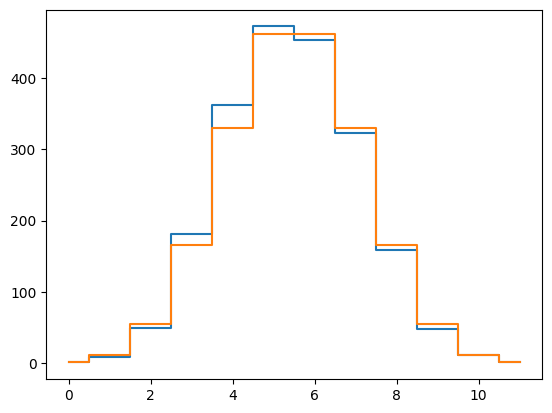

In [8]:
import math

import matplotlib.pyplot as plt
import numpy as np

def ncr(n, r):
    return np.count_nonzero(np.random.binomial(n, 0.5, 2**n) == r)

n = 11

rs = np.arange(n + 1)

bins = [ncr(n, r) for r in rs]
dist = [math.comb(n, r) for r in rs]

print("Experimental:", bins)
print("Theoretical:", dist)

fig, ax = plt.subplots()
ax.step(rs, bins, where="mid")
ax.step(rs, dist, where="mid")

Not bad, but not great. Now let's try out our theory. We want to have a precision parameter that we can tune, so what would that look like? As it increases, it should always increase the total number of dropped balls beyond $2^n$. It should also scale with $n$, so as we raise $n$, it doesn't become less effective. A good way to meet our objectives is to increase the power of 2: $2^{n + p}$ for precision factor $p$. Let's try it!

Experimental: [1.0, 11.0, 54.0, 167.0, 328.0, 464.0, 460.0, 330.0, 167.0, 55.0, 11.0, 1.0]
Theoretical: [1, 11, 55, 165, 330, 462, 462, 330, 165, 55, 11, 1]


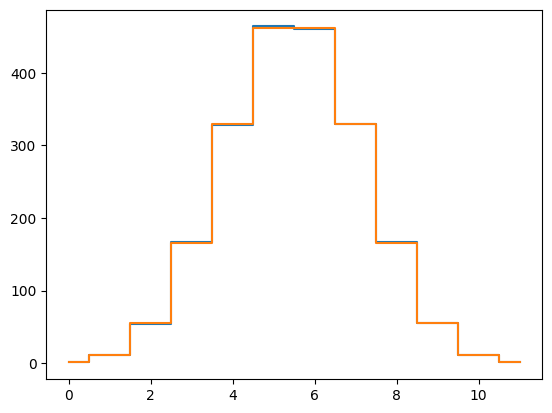

In [9]:
import math

import matplotlib.pyplot as plt
import numpy as np

def ncr(n, r, p):
    total_dropped = 2**(n + p)
    found_in_r = np.count_nonzero(np.random.binomial(n, 0.5, total_dropped) == r)
    p_r = found_in_r/total_dropped
    
    return np.round(2**n*p_r)

n = 11
p = 7

rs = np.arange(n + 1)

bins = [ncr(n, r, p) for r in rs]
dist = [math.comb(n, r) for r in rs]

print("Experimental:", bins)
print("Theoretical:", dist)

fig, ax = plt.subplots()
ax.step(rs, bins, where="mid")
ax.step(rs, dist, where="mid")

Much better. The last step is to use our high-precision Galton board-simulated choose function with our $\pi$ formula.

In [11]:
from operator import eq

import numpy as np

def ncr(n, r, p):
    total_dropped = 2**(n + p)
    found_in_r = np.count_nonzero(np.random.binomial(n, 0.5, total_dropped) == r)
    p_r = found_in_r/total_dropped
    
    return np.round(2**n*p_r)

n = 11
p = 7

pi_approx = 3*sum(ncr(2*r, r, p)/((16**r)*(2*r + 1)) for r in range(n))

print(pi_approx)
print(np.pi)
print("".join(map(str, map(int, map(eq, str(pi_approx), str(np.pi))))))

3.1415926170895565
3.141592653589793
11111111100011000


Wow! $\pi$ to 7 decimal places! Of course, this can vary, but I can still safely proclaim this a resounding success.

One question that you may be asking yourself at this point is "would this be practical with a real Galton board?" We'll save that for a future post!